# WIPRO TIME SERIERS - ANOMALY DETECTION AND SEQUENCE PREDICTION

**Requirements**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import numpy as np
from sklearn import preprocessing

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

USE_CUDA = torch.cuda.is_available() and False

env: CUDA_VISIBLE_DEVICES=0


# Load NASA data 

[from dataset readme]
The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)  unit number  
2)  time, in cycles  
3)  operational setting 1  
4)  operational setting 2  
5)  operational setting 3  
6)  sensor measurement  1  
7)  sensor measurement  2  
...  
26) sensor measurement  26  


In [2]:
file_path = './nasa_data/train_FD001.txt'
header_names = ['unit number', 'time in cycles']  + ['operational setting %d'%i for i in range(1, 4)] + [ 'sensor measurement %d'%i for i in range(1, 24)]
df_train = pd.read_csv(file_path, sep=' ', header=None, names=header_names)
df_train = df_train.dropna(axis=1, how='all')
df_train.head()

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
file_path = './nasa_data/test_FD001.txt'
header_names = ['unit number', 'time in cycles']  + ['operational setting %d'%i for i in range(1, 4)] + [ 'sensor measurement %d'%i for i in range(1, 24)]
df_test = pd.read_csv(file_path, sep=' ', header=None, names=header_names)
df_test = df_test.dropna(axis=1, how='all')
df_test.head()

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


First 50 cycles


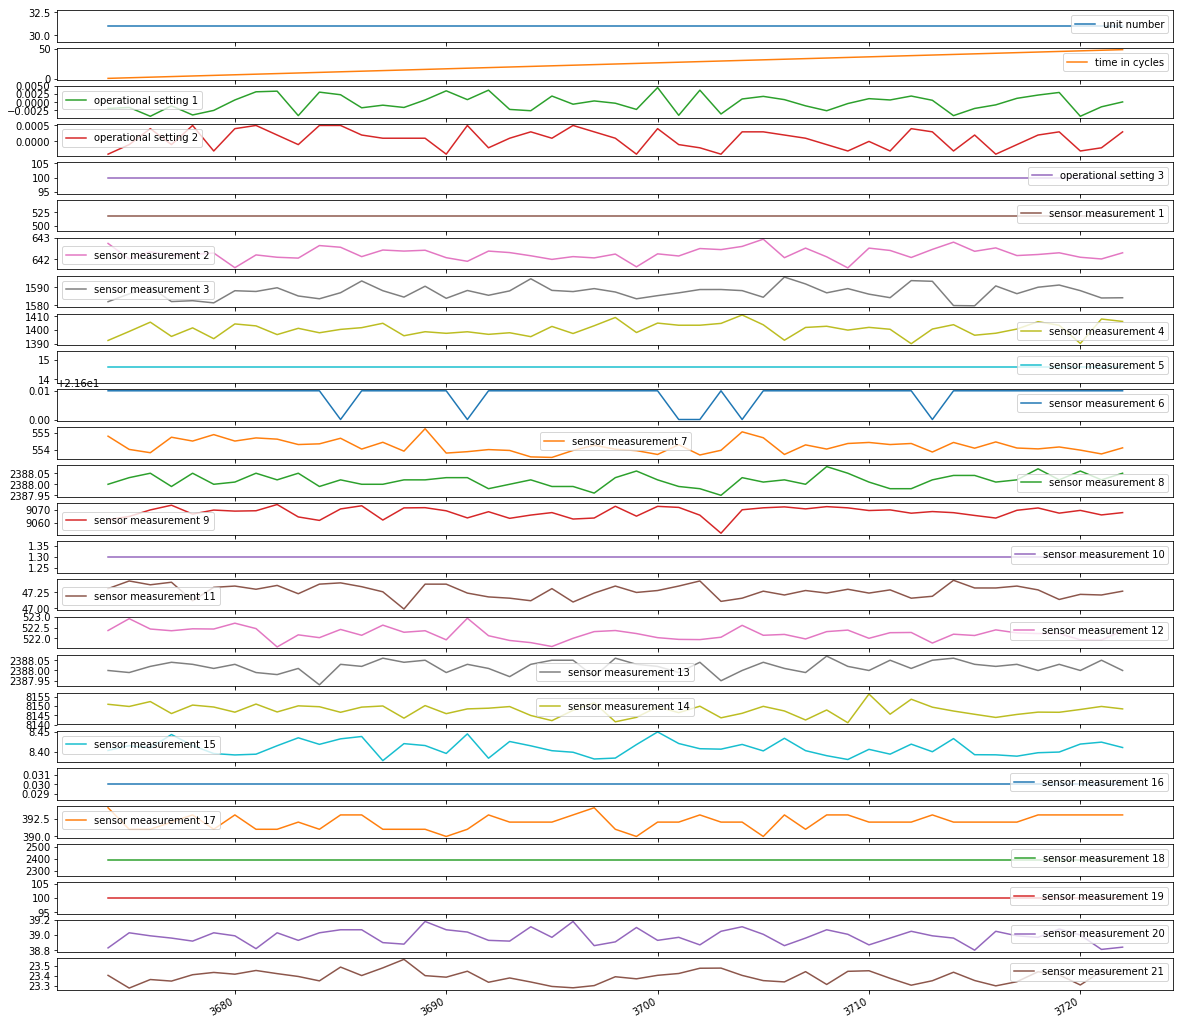

In [4]:
unit = np.random.randint(1, df_test['unit number'].max())
window_sz = 50

plot_example = df_test[(df_test['unit number'] == unit) &  (df_test['time in cycles'] < window_sz) ]
print('First 50 cycles')
ax = plot_example.plot(subplots=True, sharex=True, figsize=(20,20))

Last 50 cycles


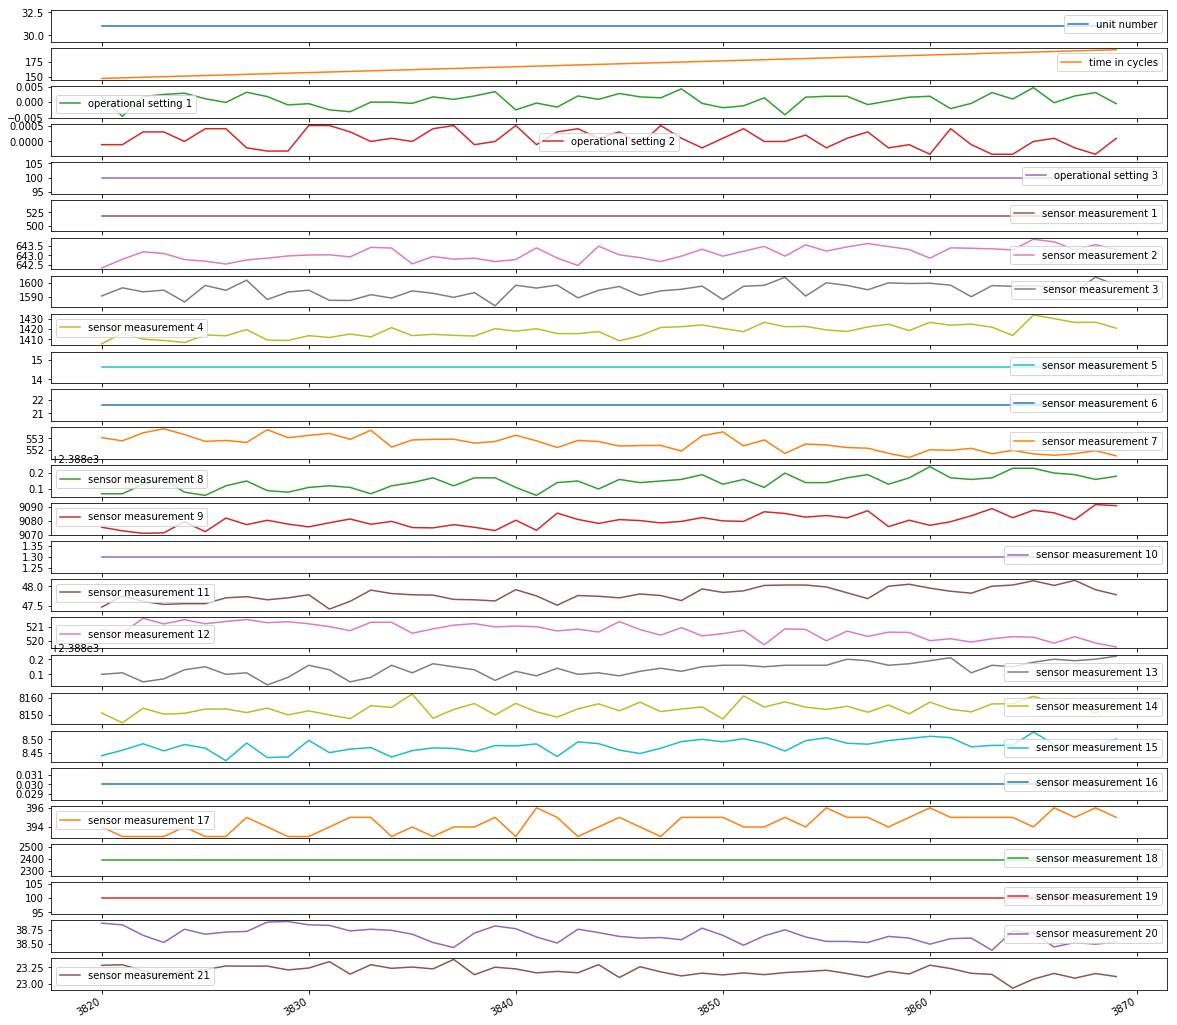

In [5]:
amount_of_cycles = df_test[(df_test['unit number'] == unit)]['time in cycles'].max()
plot_example = df_test[(df_test['unit number'] == unit) &  (amount_of_cycles - window_sz < df_test['time in cycles']) ]
print('Last 50 cycles')
ax = plot_example.plot(subplots=True, sharex=True, figsize=(20,20))

**Preprocess and normolize data
we use minmax norm:**  
`X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min`

Train data

In [6]:
cols_normalize = df_train.columns.difference(['unit number', 'time in cycles'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_train.index)
join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)
df_train = join_df.reindex(columns = df_train.columns)
df_train.head()

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


test data

In [7]:
norm_test_df = pd.DataFrame(min_max_scaler.transform(df_test[cols_normalize]), 
                            columns=cols_normalize, 
                            index=df_test.index)
df_test_join = df_test[df_test.columns.difference(cols_normalize)].join(norm_test_df)
df_test = df_test_join.reindex(columns = df_test.columns)
df_test = df_test.reset_index(drop=True)
df_test.head()

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377


For a given unit data frame generate all shifted sequences of length seq length

In [8]:
seq_length = 50

In [9]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [10]:
# pick the feature columns 
sensor_cols = ['sensor measurement ' + str(i) for i in range(1,22)]
sequence_cols = ['operational setting 1', 'operational setting 2', 'operational setting 3']
sequence_cols.extend(sensor_cols)

In [11]:
# generator for the sequences
seq_gen = (list(gen_sequence(df_train[df_train['unit number']==id], seq_length, sequence_cols)) 
           for id in df_train['unit number'].unique())

In [12]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 24)

split to train and validation

In [13]:
valid_ratio = 0.05
seq_count = seq_array.shape[0]
valid_stop_idx = int(seq_count * valid_ratio)

np.random.shuffle(seq_array)
train_data = seq_array[valid_stop_idx:]
valid_data = seq_array[:valid_stop_idx]

#  Recurrent attention based model

The idea being learn the sequential dependencys and structure via gated rnn,
and to learn spatial structure and similarity via attention mechanism. 

The Attention used in this case is inspired by https://arxiv.org/pdf/1508.04025.pdf
Where the context vector is appended to final hiddent state and are passed to output layer.
This differs to the standerd case where context is appended to input of the reccurent cell.

![attention model](atnn_img.png)

The RNN sequence is inspired by https://arxiv.org/pdf/1308.0850.pdf

Where LSTM based models are used for pedicting next time step.

![sequence prediction model](seq_pred.png)

**Once the model is sufficiently predicts next time step t,
annomalys can be detected via comparing actual time step predicted time step. **

**Model: sequence --> GRU --> attention --> FC --> out**

** Attention model utilize reccurnt ouputs and their spatial similarity for predicting next time step**

In [14]:
class AttendAndPredict(nn.Module):
    """Attention nn module that is responsible for computing the alignment scores."""

    def __init__(self, method, hidden_size, output_size):
        super(AttendAndPredict, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Define layers
        if self.method == 'general':
            self.attention = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.method == 'concat':
            self.attention = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
            
        self.fc_c = nn.Linear(self.hidden_size * 2, self.output_size)
        
        

    def forward(self, hidden, M):
        """Attend over N rnn sequence prediction outputs till time t-1 (t-2-N...t-1).
        
        After creating variables to store the attention energies, calculate their 
        values for each encoder output and return the normalized values.
        
        Args:
            M(mem_size,batch,input size): memory of which to attend over.
            hidden(1, batch, input size): hidden state.
            
        Returns:
             Normalized (0..1) energy values, re-sized to 1 x 1 x seq_len
        """
        
        mem_size = M.size()[0]
        batch_size = M.size()[1]
        
        # convert to batch first
        M = M.permute(1,0,2)
        hidden = hidden.permute(1,2,0)

        energies = self._score(hidden, M)
        a = F.softmax(energies, dim=1)
        c = a.permute(0,2,1).bmm(M)
        next_hidden_state =  F.tanh(self.fc_c(torch.cat((c.squeeze(1), hidden.squeeze(2)), 1)))
        
        return next_hidden_state, a
        
    def _score(self, hidden, M):
        """
        Calculate the relevance of a particular encoder output in respect to the decoder hidden.
        Args:
            hidden: decoder hidden output used for condition.
            M(batch,seq_len,input_size): memory of which to attend over.
            hidden(1, batch, input size): hidden state.
        """

        if self.method == 'dot':
            # TODO: Not tested
            energy = hidden.dot(M)
        elif self.method == 'general':
            energy = self.attention(M)
            energy = torch.bmm(energy, hidden)#hidden.dot(energy)
        elif self.method == 'concat':
            # TODO: Not tested
            energy = self.attention(torch.cat((hidden, M), 1))
            energy = self.other.dor(energy)
        return energy



In [15]:
class SeqRnnAttnAndPred(nn.Module):
    """
    SequenceAttnPred - Recurrent Atteniton based model for predicting next time step.
    """
    def __init__(self, input_size, hidden_size, output_size,
                 rnn_layers=1, atnn_method='general', memory_size=-1):
        """
        args:
        input_size: size of elemnt of sequnece.
        hidden_size: size of hidden state of RNN (same as output if only 1 RNN).
        output_size: size of output tensor.
        rnn_layers: amount of stacked RNN's (see any basic seq2seq paper).
        atnn_method: type of attention to use.
        memory_size: amount of rnn output's to aggregate and attend over.
        """
        super(SeqRnnAttnAndPred, self).__init__()
        self._rnn_layer = nn.GRU(input_size, hidden_size, num_layers=rnn_layers)
        self._atnn_layer = AttendAndPredict(atnn_method, hidden_size, output_size)
        self._memory_size = memory_size
        self._rnn_layers = rnn_layers
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._fc_out = nn.Linear(self._hidden_size , self._output_size)

        
    def forward(self, inputs, hidden):
        """
        args:
        inputs(seq_len,batch,input_len): input sequence predict seq_len + 1
        """
        seq_len = inputs.size()[0]
        
        # in case of 1 rnn layer output == hidden.
        seqrnn_output, hidden = self._rnn_layer(inputs, hidden)
        self.memory = seqrnn_output[-self._memory_size-1:-1]
        hidden_t = seqrnn_output[-1].unsqueeze(0)
        hidden_t_hat, alignment = self._atnn_layer(hidden_t, self.memory)
        outputs = self._fc_out(hidden_t_hat)
        
        return outputs, alignment
    
    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self._rnn_layers, batch_size, self._hidden_size))
        hidden = hidden.cuda() if USE_CUDA else hidden
        return hidden
        
   

** Helper functions **

In [16]:
def show_plot(train, test):
    plt.figure()
    tr, = plt.plot(range(len(train)), train, label='train')
    ts, = plt.plot(range(len(test)), test, label='validation')
    
    plt.ylabel('MSE')
    plt.xlabel('train step')
    plt.title('Train & Validation loss')
    
    plt.legend()
    
def change_lr(optimizer, lr_new_val):
    print("updating learning rate to: %f"%lr_new_val)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_new_val
    return optimizer

** Training procedure**

Run model on data

In [17]:
def run(input_seq, model, criterion, batch_size, train=False, optimizer=None):
    """
    Train for a given sequence batch size.
    Args:
    input_seq(batch_size,seq_len,input_size): tensor containin sequences.
    model: input model - batch is first dim.
    criterion: distance measure i.e. l1, l2 etc.
    optimizer: SGD, ADAM etc.
    """ 
    hidden = model.init_hidden(batch_size)
    
    input_seq = input_seq.transpose(0, 1)
    preds, alignment = model(input_seq[:-1], hidden)
    loss = criterion(preds, input_seq[-1])
    
    if train:
        model.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.data[0], preds

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

Full train procedure

In [24]:
def train_procedure(train_data_np, valid_data_np, model, n_epoch, batch_size, learning_rate=0.01):
    
    plot_losses_avg = []
    plot_loss_total = 0  # Reset every check_loss_every
    valid_losses = []
    check_loss_every = 100
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.MSELoss()
    if USE_CUDA:
        criterion = criterion.cuda()
    
    batchs_count = train_data_np.shape[0] / batch_size
    
    valid_batch_size = 20
    valid_batchs_count = valid_data_np.shape[0] / valid_batch_size
    
    train_data = Variable(torch.from_numpy(train_data_np.astype('float32')), requires_grad=False)
    valid_data = Variable(torch.from_numpy(valid_data_np.astype('float32')), requires_grad=False)
    if USE_CUDA:
        train_data = train_data.cuda()
        valid_data = valid_data.cuda()
        
    print('Starting training...')
    for e in range(n_epoch):
        
        plot_loss_total = 0
        for batch_id in range(batchs_count):
            train_batch = train_data[batch_id * batch_size : batch_id * batch_size + batch_size]
            
            loss, _ = run(train_batch, model, criterion, batch_size, train=True, optimizer=optimizer)
            plot_loss_total += loss 
                
        plot_losses_avg.append(float(plot_loss_total / batchs_count))
        
        valid_loss = 0
        for batch_id in range(valid_batchs_count):
            valid_batch = valid_data[batch_id * valid_batch_size : batch_id * valid_batch_size + valid_batch_size]
            
            loss, _ = run(valid_batch, model, criterion, valid_batch_size)
            valid_loss += loss
            
        valid_losses.append(float(valid_loss / valid_batchs_count))
        
        print("[epoch %d : %d] train loss %f valid loss %f"%(e, n_epoch, plot_losses_avg[-1], valid_losses[-1]))
        
    return plot_losses_avg, valid_losses
            

** Main Entry Point **

Load data and set hyperparams

In [25]:
print("train shape: {} validation shape: {}".format(train_data.shape, valid_data.shape))

input_size = train_data.shape[-1]
hidden_size = input_size # disregarded when rnn_layers=1
output_size = input_size
batch_size = 120
rnn_layers = 2
memory_size = 40
learning_rate = 0.01


train shape: (14850, 50, 24) validation shape: (781, 50, 24)


In [26]:

model = SeqRnnAttnAndPred(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                          rnn_layers=rnn_layers, atnn_method='general',
                          memory_size=memory_size)

if USE_CUDA:
    model = model.cuda()

tr_loss, vl_loss = train_procedure(train_data,
                                   valid_data,
                                   model,
                                   n_epoch=1000,
                                   batch_size=120,
                                   learning_rate=learning_rate
                                  )

Starting training...
[epoch 0 : 1000] train loss 0.049249 valid loss 0.013555
[epoch 1 : 1000] train loss 0.013598 valid loss 0.013229
[epoch 2 : 1000] train loss 0.013247 valid loss 0.012863
[epoch 3 : 1000] train loss 0.012843 valid loss 0.012432
[epoch 4 : 1000] train loss 0.012363 valid loss 0.011921
[epoch 5 : 1000] train loss 0.011798 valid loss 0.011326
[epoch 6 : 1000] train loss 0.011156 valid loss 0.010673
[epoch 7 : 1000] train loss 0.010479 valid loss 0.010014
[epoch 8 : 1000] train loss 0.009824 valid loss 0.009408
[epoch 9 : 1000] train loss 0.009246 valid loss 0.008895
[epoch 10 : 1000] train loss 0.008767 valid loss 0.008481
[epoch 11 : 1000] train loss 0.008386 valid loss 0.008157
[epoch 12 : 1000] train loss 0.008091 valid loss 0.007910
[epoch 13 : 1000] train loss 0.007867 valid loss 0.007724
[epoch 14 : 1000] train loss 0.007699 valid loss 0.007586
[epoch 15 : 1000] train loss 0.007576 valid loss 0.007485
[epoch 16 : 1000] train loss 0.007486 valid loss 0.007411
[ep

[epoch 141 : 1000] train loss 0.006373 valid loss 0.006419
[epoch 142 : 1000] train loss 0.006373 valid loss 0.006418
[epoch 143 : 1000] train loss 0.006373 valid loss 0.006418
[epoch 144 : 1000] train loss 0.006372 valid loss 0.006418
[epoch 145 : 1000] train loss 0.006372 valid loss 0.006417
[epoch 146 : 1000] train loss 0.006371 valid loss 0.006417
[epoch 147 : 1000] train loss 0.006371 valid loss 0.006417
[epoch 148 : 1000] train loss 0.006371 valid loss 0.006417
[epoch 149 : 1000] train loss 0.006370 valid loss 0.006416
[epoch 150 : 1000] train loss 0.006370 valid loss 0.006416
[epoch 151 : 1000] train loss 0.006370 valid loss 0.006416
[epoch 152 : 1000] train loss 0.006369 valid loss 0.006416
[epoch 153 : 1000] train loss 0.006369 valid loss 0.006416
[epoch 154 : 1000] train loss 0.006369 valid loss 0.006415
[epoch 155 : 1000] train loss 0.006368 valid loss 0.006415
[epoch 156 : 1000] train loss 0.006368 valid loss 0.006415
[epoch 157 : 1000] train loss 0.006368 valid loss 0.0064

[epoch 280 : 1000] train loss 0.006344 valid loss 0.006398
[epoch 281 : 1000] train loss 0.006344 valid loss 0.006398
[epoch 282 : 1000] train loss 0.006344 valid loss 0.006398
[epoch 283 : 1000] train loss 0.006343 valid loss 0.006398
[epoch 284 : 1000] train loss 0.006343 valid loss 0.006398
[epoch 285 : 1000] train loss 0.006343 valid loss 0.006398
[epoch 286 : 1000] train loss 0.006343 valid loss 0.006398
[epoch 287 : 1000] train loss 0.006343 valid loss 0.006398
[epoch 288 : 1000] train loss 0.006343 valid loss 0.006398
[epoch 289 : 1000] train loss 0.006343 valid loss 0.006397
[epoch 290 : 1000] train loss 0.006343 valid loss 0.006397
[epoch 291 : 1000] train loss 0.006342 valid loss 0.006397
[epoch 292 : 1000] train loss 0.006342 valid loss 0.006397
[epoch 293 : 1000] train loss 0.006342 valid loss 0.006397
[epoch 294 : 1000] train loss 0.006342 valid loss 0.006397
[epoch 295 : 1000] train loss 0.006342 valid loss 0.006397
[epoch 296 : 1000] train loss 0.006342 valid loss 0.0063

[epoch 419 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 420 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 421 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 422 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 423 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 424 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 425 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 426 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 427 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 428 : 1000] train loss 0.006329 valid loss 0.006388
[epoch 429 : 1000] train loss 0.006328 valid loss 0.006388
[epoch 430 : 1000] train loss 0.006328 valid loss 0.006387
[epoch 431 : 1000] train loss 0.006328 valid loss 0.006387
[epoch 432 : 1000] train loss 0.006328 valid loss 0.006387
[epoch 433 : 1000] train loss 0.006328 valid loss 0.006387
[epoch 434 : 1000] train loss 0.006328 valid loss 0.006387
[epoch 435 : 1000] train loss 0.006328 valid loss 0.0063

[epoch 558 : 1000] train loss 0.006320 valid loss 0.006382
[epoch 559 : 1000] train loss 0.006320 valid loss 0.006382
[epoch 560 : 1000] train loss 0.006320 valid loss 0.006382
[epoch 561 : 1000] train loss 0.006319 valid loss 0.006382
[epoch 562 : 1000] train loss 0.006319 valid loss 0.006382
[epoch 563 : 1000] train loss 0.006319 valid loss 0.006382
[epoch 564 : 1000] train loss 0.006319 valid loss 0.006382
[epoch 565 : 1000] train loss 0.006319 valid loss 0.006382
[epoch 566 : 1000] train loss 0.006319 valid loss 0.006382
[epoch 567 : 1000] train loss 0.006319 valid loss 0.006381
[epoch 568 : 1000] train loss 0.006319 valid loss 0.006381
[epoch 569 : 1000] train loss 0.006319 valid loss 0.006381
[epoch 570 : 1000] train loss 0.006319 valid loss 0.006381
[epoch 571 : 1000] train loss 0.006319 valid loss 0.006381
[epoch 572 : 1000] train loss 0.006319 valid loss 0.006381
[epoch 573 : 1000] train loss 0.006319 valid loss 0.006381
[epoch 574 : 1000] train loss 0.006319 valid loss 0.0063

[epoch 697 : 1000] train loss 0.006312 valid loss 0.006378
[epoch 698 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 699 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 700 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 701 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 702 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 703 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 704 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 705 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 706 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 707 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 708 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 709 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 710 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 711 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 712 : 1000] train loss 0.006312 valid loss 0.006377
[epoch 713 : 1000] train loss 0.006312 valid loss 0.0063

[epoch 836 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 837 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 838 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 839 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 840 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 841 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 842 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 843 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 844 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 845 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 846 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 847 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 848 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 849 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 850 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 851 : 1000] train loss 0.006306 valid loss 0.006374
[epoch 852 : 1000] train loss 0.006306 valid loss 0.0063

[epoch 975 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 976 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 977 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 978 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 979 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 980 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 981 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 982 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 983 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 984 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 985 : 1000] train loss 0.006301 valid loss 0.006372
[epoch 986 : 1000] train loss 0.006300 valid loss 0.006372
[epoch 987 : 1000] train loss 0.006300 valid loss 0.006372
[epoch 988 : 1000] train loss 0.006300 valid loss 0.006372
[epoch 989 : 1000] train loss 0.006300 valid loss 0.006372
[epoch 990 : 1000] train loss 0.006300 valid loss 0.006372
[epoch 991 : 1000] train loss 0.006300 valid loss 0.0063

Plot train and Validation loss + save trained wights|

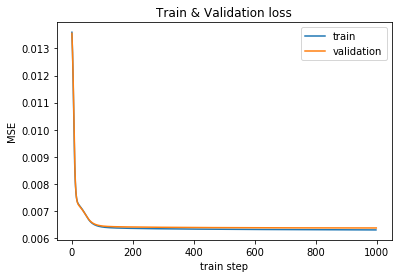

In [27]:
show_plot(tr_loss[1:], vl_loss)
torch.save(model.state_dict(), "./saved_models/pred_nasa_seq")

** Run Evaluation **

In [22]:
def evaluate(test_data, model, window_sz):
    
    loss_total = 0  # Reset every print_every
    test_count = 0

    criterion = nn.MSELoss().cuda()
    
    for seq in test_data:
        seq_len = seq.shape[0]
        for i in range(seq_len - window_sz):
            test_seq = seq[i: i + window_sz]
            test_seq = Variable(torch.from_numpy(test_seq.astype('float32')), requires_grad=False).unsqueeze(0)
            if USE_CUDA:
                test_seq = test_seq.cuda()
            loss, _ = run(test_seq, model, criterion, 1, False)
            loss_total += loss
            test_count += 1
    return loss_total / test_count
    

In [23]:
model = SeqRnnAttnAndPred(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                          rnn_layers=rnn_layers, atnn_method='general',
                          memory_size=memory_size)
if USE_CUDA:
    model = model.cuda()
    
model.load_state_dict(torch.load("./saved_models/pred_nasa_seq"))


evaluate(test_set, model)

NameError: name 'test_set' is not defined